In [27]:
import matplotlib.pyplot as plt
import numpy as np
from src.vae_model import vae_model
from src.visualization import plot_latent_space_with_tsne, plot_loss_history, plot_voxel
from src.voxel_util import (
    gen_voxel_ball_data,
    gen_voxel_brick_data,
    random_voxel_ball,
    random_voxel_brick,
)
from tensorflow.keras.optimizers import Adam

In [28]:
# sources
# https://github.com/IsaacGuan/3D-VAE/blob/master/train.py
# https://github.com/ffriese/voxel_vae/tree/master
# https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/Generative/VAE.py

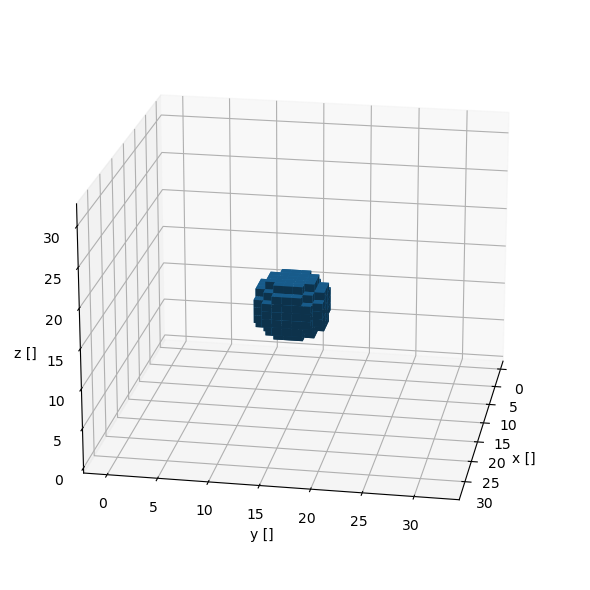

In [29]:
ball = True
if ball:
    d = 4
    plot_voxel(random_voxel_ball(d=d))
else:
    d_xyz = [5, 5, 5]
    plot_voxel(random_voxel_brick(d_xyz=d_xyz))

In [30]:
n_gammas = 500
if ball:
    gamma_train = gen_voxel_ball_data(num=n_gammas, d=d)
else:
    gamma_train = gen_voxel_brick_data(num=n_gammas, d_xyz=d_xyz)

print(gamma_train.shape)

(500, 32, 32, 32, 1)


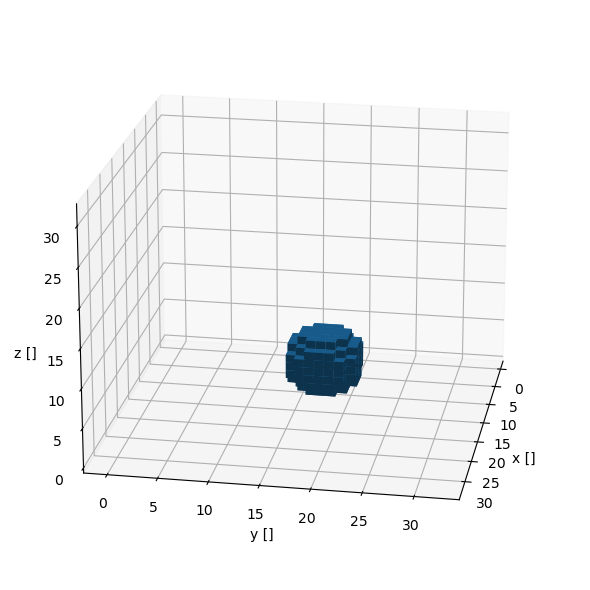

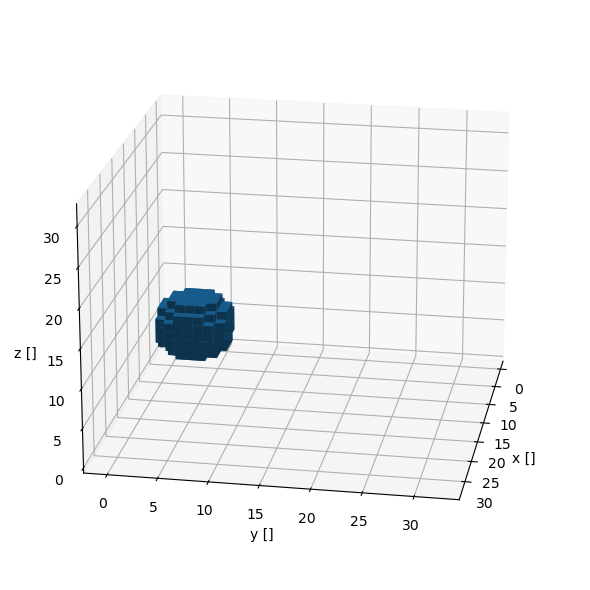

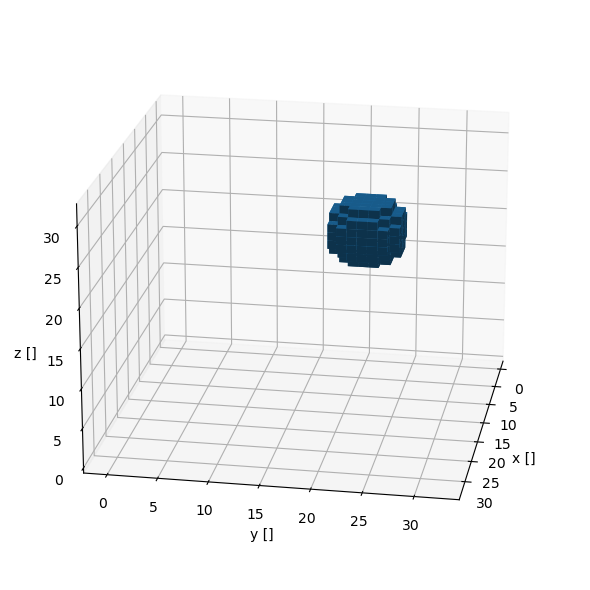

In [31]:
ns = 100
for idx in np.random.randint(0, ns, size=3):
    plot_voxel(gamma_train[idx, :, :, :, 0])

In [ ]:
vae = vae_model(input_shape=(32, 32, 32, 1), beta=1.05)
vae.compile(optimizer=Adam())
epoch_num = 250
batch_size = 100

history = vae.fit(gamma_train, epochs=epoch_num, batch_size=batch_size)
# callbacks = [LearningRateScheduler(learning_rate_scheduler)]

Epoch 1/250
5/5 [==============================] - 6s 812ms/step - loss: 2164.0132 - reconstruction_loss: 1932.3340 - kl_loss: 0.0090
Epoch 2/250
5/5 [==============================] - 4s 774ms/step - loss: 1768.1137 - reconstruction_loss: 1774.7338 - kl_loss: 0.0239
Epoch 3/250
5/5 [==============================] - 4s 820ms/step - loss: 1708.6732 - reconstruction_loss: 1683.5673 - kl_loss: 0.0801
Epoch 4/250
5/5 [==============================] - 4s 782ms/step - loss: 1610.3569 - reconstruction_loss: 1600.6312 - kl_loss: 0.5050
Epoch 5/250
5/5 [==============================] - 4s 774ms/step - loss: 1529.2534 - reconstruction_loss: 1516.4050 - kl_loss: 3.5868
Epoch 6/250
5/5 [==============================] - 4s 784ms/step - loss: 1492.7978 - reconstruction_loss: 1479.4368 - kl_loss: 11.1110
Epoch 7/250
5/5 [==============================] - 4s 786ms/step - loss: 1486.9552 - reconstruction_loss: 1469.3112 - kl_loss: 15.7102
Epoch 8/250
5/5 [==============================] - 4s 784ms/

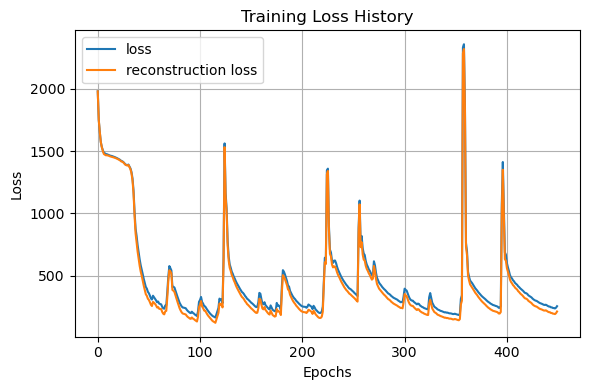

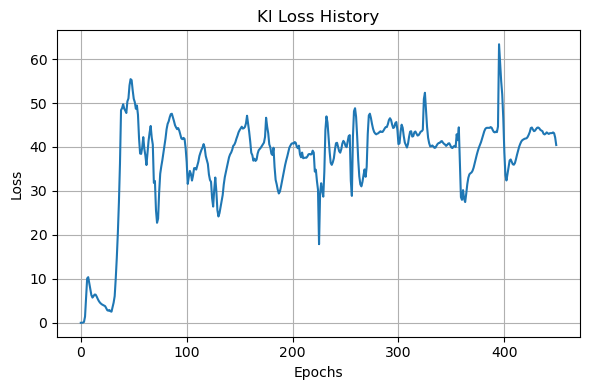

In [14]:
plot_loss_history(history)

plt.figure(figsize=(6, 4))
plt.title("Kl Loss History")
plt.plot(history.history["kl_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()
plt.show()

In [15]:
if ball:
    gamma_test = gen_voxel_ball_data(num=100, d=d)
else:
    gamma_test = gen_voxel_brick_data(num=100, d_xyz=d_xyz)

4/4 [==============================] - 0s 34ms/step


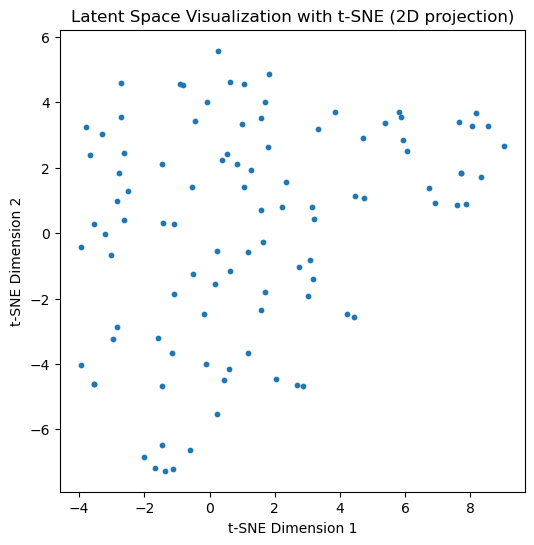

In [16]:
z_mean, z_log_var, z = vae.encoder.predict(gamma_test)
plot_latent_space_with_tsne(z_log_var)

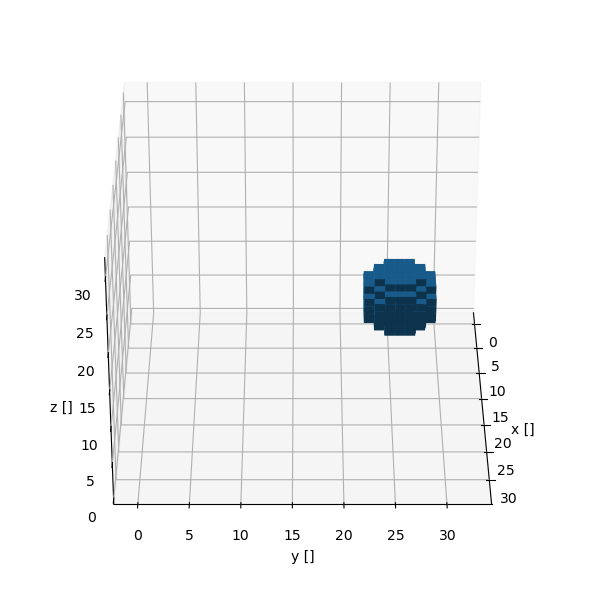

1/1 [==============================] - 0s 29ms/step


In [25]:
if ball:
    sgl_data = gen_voxel_ball_data(1, d=d)
else:
    sgl_data = gen_voxel_brick_data(1, d_xyz=d_xyz)
plot_voxel(sgl_data[0, :, :, :, 0], azim=0, elev=30)
z_mean, z_log_var, z = vae.encoder.predict(sgl_data)

1/1 [==============================] - 0s 32ms/step


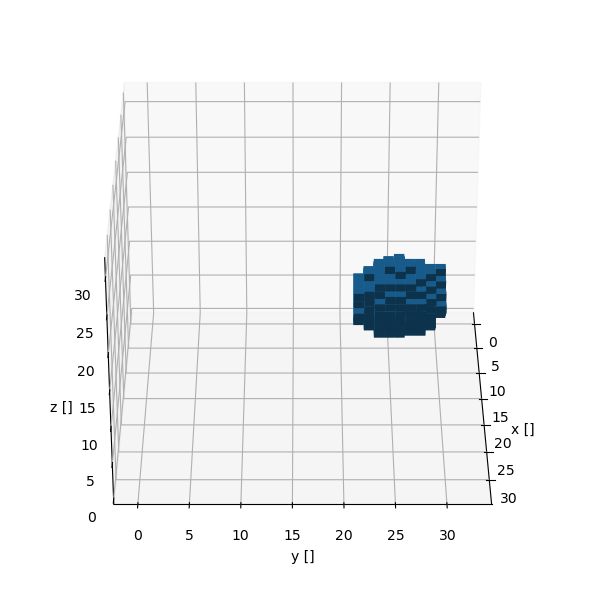

In [26]:
sgl_pred = vae.decoder.predict(z)
sgl_pred = np.squeeze(sgl_pred, axis=4)
sgl_pred = np.squeeze(sgl_pred, axis=0)
# sgl_pred = np.abs(np.round(sgl_pred))
sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)

plot_voxel(sgl_pred, azim=0, elev=30)

In [ ]:
plt.stem(np.concatenate(np.concatenate(sgl_pred)))

In [ ]:
vae.save_weights("models/vae_weights_beta.h5")
vae.save("models/vae_beta.keras")

## Load VAE